# Exercises
insert some Batch Normalization layers into the generator and discriminator networks and see if it helps training.

## Create training data

In [1]:
from keras.datasets import mnist
import numpy as np

# load the mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize the data
x_train = x_train.astype('float32') / 255 *2 -1
x_test = x_test.astype('float32') / 255 *2 -1

# reshape the data
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

11490434/11490434 [==============================] - 0s 0us/step


## Setting up the hyperparameters

In [2]:
n_learn = 10001 # number of learning
interval = 1000 # interval of learning
batch_size = 32 # batch size
n_noize = 128 # number of noize
img_size = 28 # image size
alpha = 0.2 # alpha for leaky relu

# set up the optimizer
from keras.optimizers import Adam
opt = Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Generator
Activation in hidden layer:  LeakyReLU

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization

# generator
generator = Sequential()
generator.add(Dense(256, input_dim=n_noize))
generator.add(LeakyReLU(alpha=alpha))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=alpha))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=alpha))
generator.add(Dense(img_size*img_size, activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33024     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

## Discriminator
Activation in hidden layer:  LeakyReLU
loss:  binary_crossentropy

In [4]:
# discriminator
discriminator = Sequential()
discriminator.add(Dense(512, input_dim=img_size*img_size))
discriminator.add(LeakyReLU(alpha=alpha))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=alpha))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

# compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


## Combine the generator and discriminator

In [5]:
from keras.layers import Input
from keras.models import Model

# training the discriminator only when training the GAN
discriminator.trainable = False

# the discriminator determines the image created by the generator for the noise
noize = Input(shape=(n_noize,))
img = generator(noize)
reality = discriminator(img)

# combine the generator and the discriminator
comb = Model(noize, reality)
comb.compile(loss='binary_crossentropy', optimizer=opt)
comb.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1496592   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 2,030,097
Trainable params: 1,495,056
Non-trainable params: 535,041
_________________________________________________________________


## Create the images

In [6]:
import matplotlib.pyplot as plt
def gerenate_img(i):
    # generate the image
    n_row = 5
    n_col = 5
    noize = np.random.normal(0, 1, (n_row*n_col, n_noize))
    gen_imgs = generator.predict(noize)
    gen_imgs = 0.5 * gen_imgs + 0.5

    matrix_image = np.zeros((img_size*n_row, img_size*n_col))

    # arrange the generated images into a single image
    for j in range(n_row):
        for k in range(n_col):
            matrix_image[j*img_size:(j+1)*img_size, k*img_size:(k+1)*img_size] = gen_imgs[j*n_col+k].reshape(img_size, img_size)
    
    # show the image
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix_image, cmap='Greys_r')
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.show()

## Training

epoch: 0, loss_fake: 0.580928, loss_real: 1.914406, loss_comb: 1.177487, acc_fake: 0.937500, acc_real: 0.000000
1/1 [==============================] - 0s 20ms/step


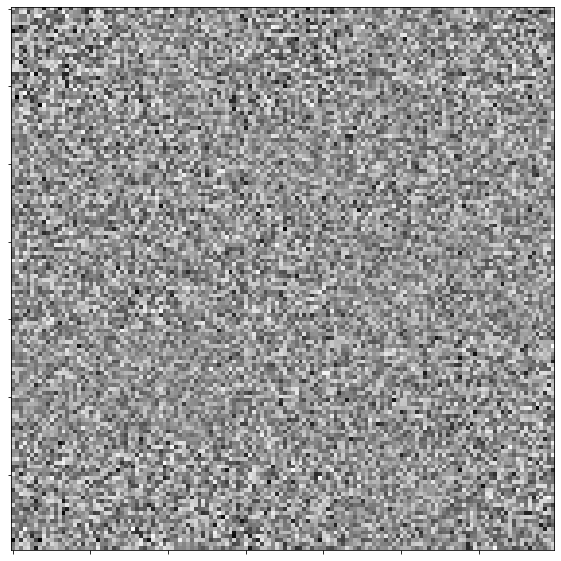

epoch: 1000, loss_fake: 0.758651, loss_real: 0.618495, loss_comb: 0.671300, acc_fake: 0.187500, acc_real: 0.687500
1/1 [==============================] - 0s 18ms/step


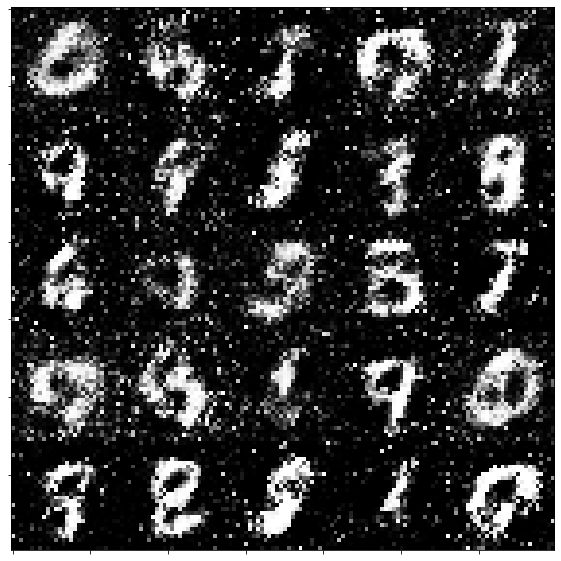

epoch: 2000, loss_fake: 0.731998, loss_real: 0.685117, loss_comb: 0.689975, acc_fake: 0.500000, acc_real: 0.500000
1/1 [==============================] - 0s 23ms/step


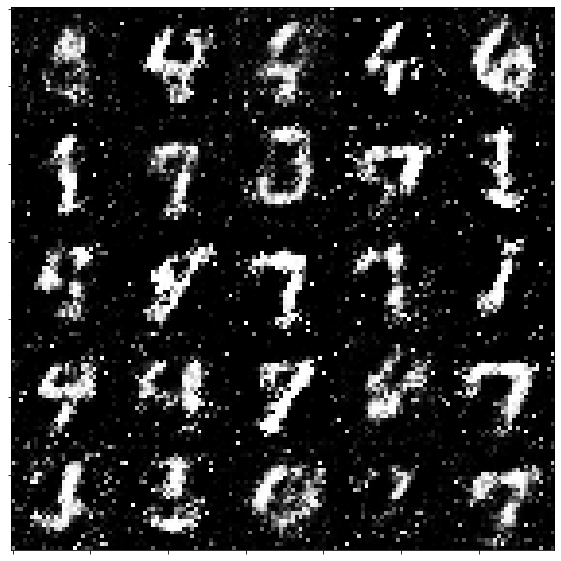

epoch: 3000, loss_fake: 0.704987, loss_real: 0.654060, loss_comb: 0.717362, acc_fake: 0.437500, acc_real: 0.687500
1/1 [==============================] - 0s 18ms/step


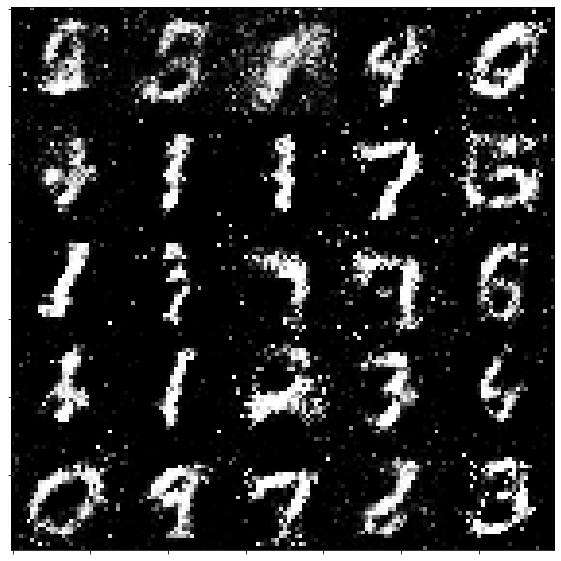

epoch: 4000, loss_fake: 0.704770, loss_real: 0.652790, loss_comb: 0.739277, acc_fake: 0.625000, acc_real: 0.625000
1/1 [==============================] - 0s 20ms/step


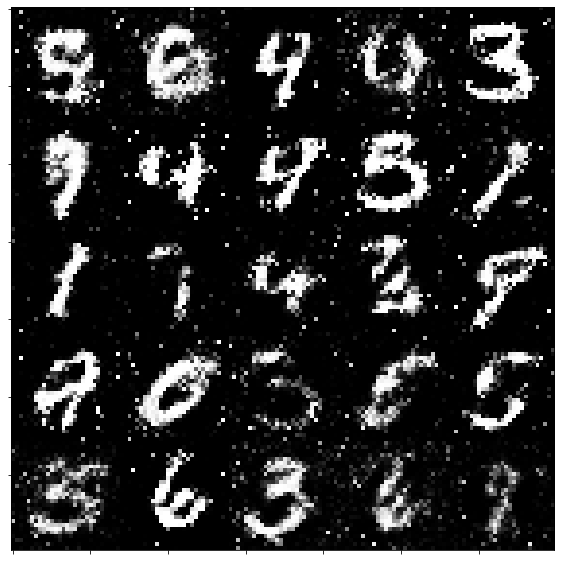

epoch: 5000, loss_fake: 0.747683, loss_real: 0.581128, loss_comb: 0.758686, acc_fake: 0.437500, acc_real: 0.875000
1/1 [==============================] - 0s 18ms/step


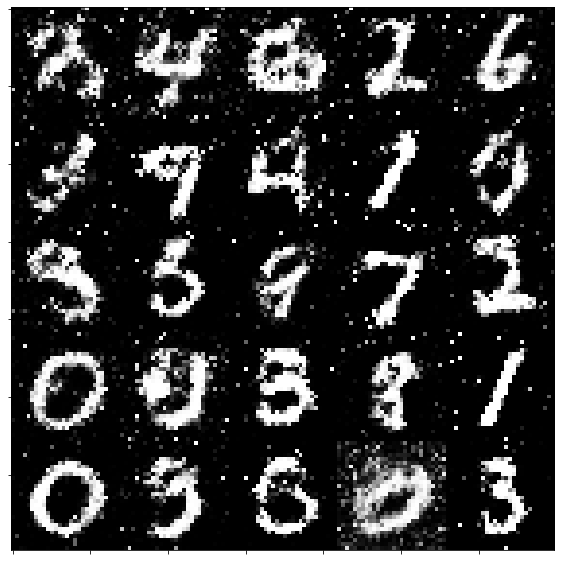

epoch: 6000, loss_fake: 0.589272, loss_real: 0.713933, loss_comb: 0.730043, acc_fake: 0.687500, acc_real: 0.687500
1/1 [==============================] - 0s 20ms/step


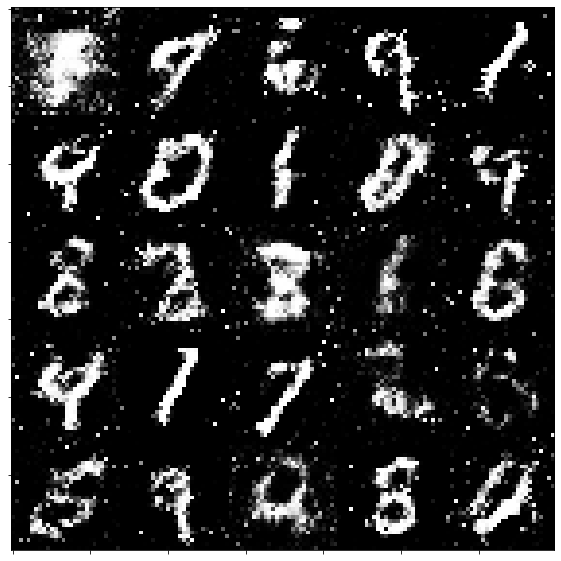

epoch: 7000, loss_fake: 0.734004, loss_real: 0.606256, loss_comb: 0.717520, acc_fake: 0.375000, acc_real: 0.812500
1/1 [==============================] - 0s 30ms/step


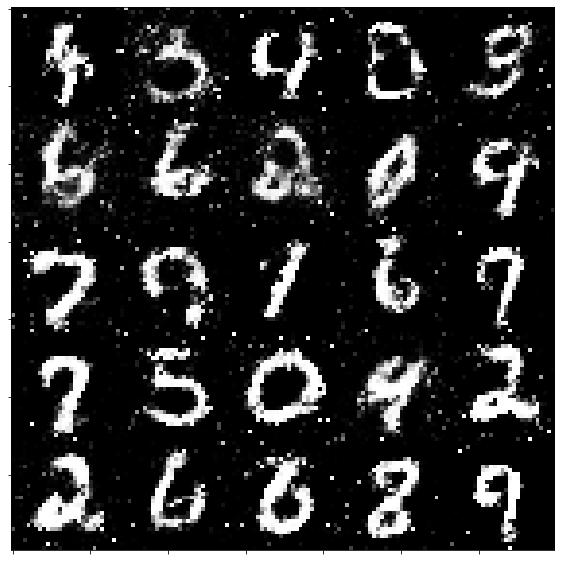

epoch: 8000, loss_fake: 0.678289, loss_real: 0.625091, loss_comb: 0.745278, acc_fake: 0.562500, acc_real: 0.750000
1/1 [==============================] - 0s 17ms/step


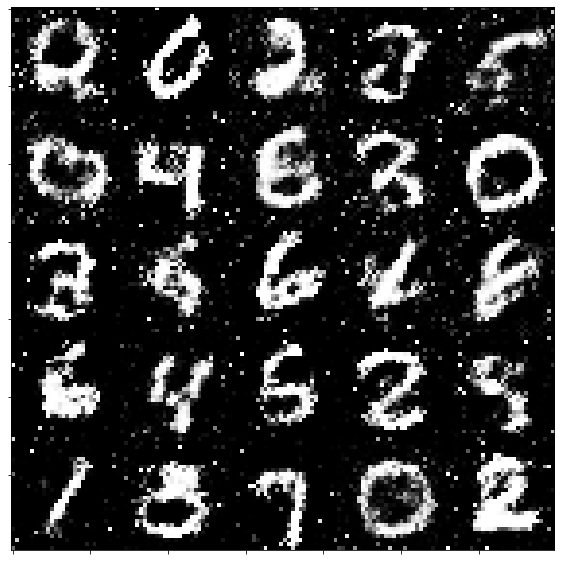

epoch: 9000, loss_fake: 0.637755, loss_real: 0.613633, loss_comb: 0.748041, acc_fake: 0.562500, acc_real: 0.750000
1/1 [==============================] - 0s 34ms/step


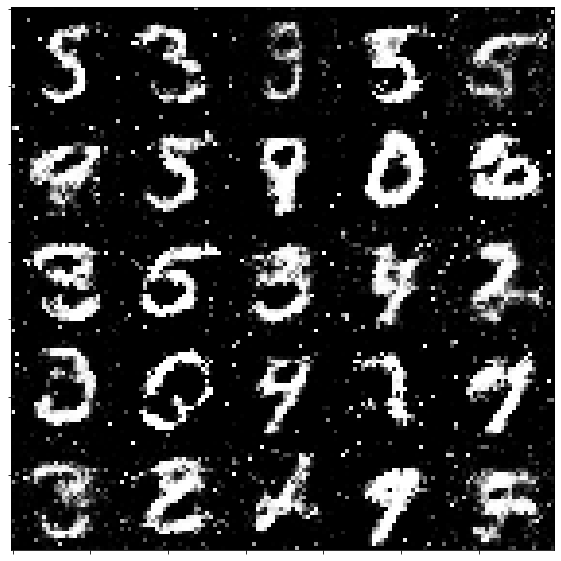

epoch: 10000, loss_fake: 0.622768, loss_real: 0.699490, loss_comb: 0.702519, acc_fake: 0.625000, acc_real: 0.500000
1/1 [==============================] - 0s 34ms/step


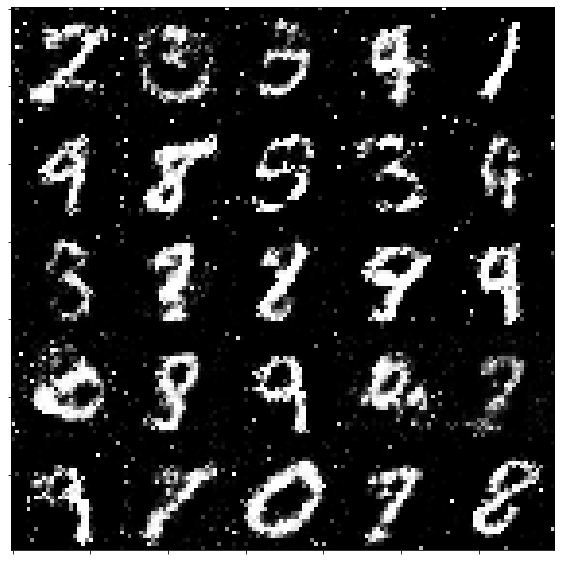

In [8]:
# set up the learning
batch_half = int(batch_size / 2)
loss_record = np.zeros((n_learn, 3))
acc_record = np.zeros((n_learn, 2))

# learning
for i in range(n_learn):
    # train the discriminator with the generated images
    g_noize = np.random.normal(0, 1, (batch_half, n_noize))
    g_imgs = generator.predict(g_noize,verbose=0)
    loss_fake, acc_fake = discriminator.train_on_batch(g_imgs, np.zeros((batch_half, 1)))
    loss_record[i, 0] = loss_fake
    acc_record[i, 0] = acc_fake

    # train the discriminator with the real images
    idx = np.random.randint(0, x_train.shape[0], batch_half)
    real_imgs = x_train[idx, :]
    loss_real, acc_real = discriminator.train_on_batch(real_imgs, np.ones((batch_half, 1)))
    loss_record[i, 1] = loss_real
    acc_record[i, 1] = acc_real

    # train the generator withe the combined model
    c_noize = np.random.normal(0, 1, (batch_size, n_noize))
    loss_comb = comb.train_on_batch(c_noize, np.ones((batch_size, 1)))
    loss_record[i, 2] = loss_comb

    # show the learning process
    if i % interval == 0:
        print('epoch: %d, loss_fake: %f, loss_real: %f, loss_comb: %f, acc_fake: %f, acc_real: %f' % (i, loss_fake, loss_real, loss_comb, acc_fake, acc_real))
        gerenate_img(i)

## History of the loss and the accuracy

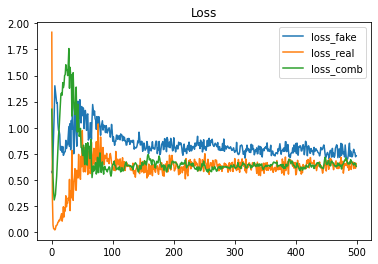

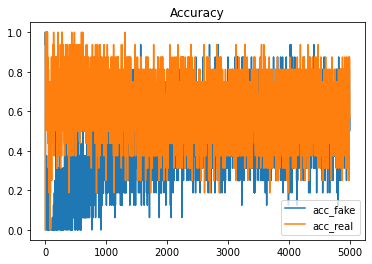

In [10]:
# history of the loss
n_plt_loss = 500
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 0], label='loss_fake')
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 1], label='loss_real')
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 2], label='loss_comb')
plt.legend()
plt.title('Loss')
plt.show()

# history of the accuracy
n_plt_acc = 5000
plt.plot(np.arange(n_plt_acc), acc_record[:n_plt_acc, 0], label='acc_fake')
plt.plot(np.arange(n_plt_acc), acc_record[:n_plt_acc, 1], label='acc_real')
plt.legend()
plt.title('Accuracy')
plt.show()